# Chapter 3. MCMC 블랙박스 열기
---
<img src='https://alexioannides.github.io/images/data_science/mcmc_vi_pymc3/output_19_1.png' width =700>

**MCMC를 다루는 이유**
1. 베이지안 추론 책이라면 MCMC를 다뤄야됨.
2. MCMC과정을 알면 알고리즘의 수렴 여부를 간파할 수 있다.
3. 사후확률표본의 진정한 의미를 알 수 있다.

In [34]:
## Basics
from __future__ import absolute_import, division, print_function
warning_status = "ignore" #@param ["ignore", "always", "module", "once", "default", "error"]
import warnings
warnings.filterwarnings(warning_status)
with warnings.catch_warnings():
    warnings.filterwarnings(warning_status, category=DeprecationWarning)
    warnings.filterwarnings(warning_status, category=UserWarning)
    
## python packages
import os
import numpy as np
import pandas as pd

## visualization packages
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import iplot

## import tensorflow
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

## Color map
class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()

print(tf.__version__)
print(tfp.__version__)
tf.random.set_seed(42) # life is 42

2.2.0
0.10.0


---

## 3.1 베이지안 지형(Bayesian Landscape)
#### 시작하기
- $N$개의 rv에 대한 베이지안 추론을 할 때, 이에 대한 prior distribution이 존재할 수 있는 $N$차원의 space를 만든다.
- $N$개의 rv에 대한 prior distribution은 $N$차원의 space에 대한 surface로 정의함.
- 해석학적으로... $y = f(\mathbf{X}) \qquad \mathbf{X} = [x_1, x_2, \cdots x_n]$

##### 두 랜덤변수 ($x_1$, $x_2$)에 대하여 각각의 사전확률분포가 Uniform(0,5)를 따를때, prior landscape.

##### 두 랜덤변수 ($x_1$, $x_2$)에 대하여 각각의 사전확률분포가 $Exp(3)$, $Exp(10)$를 따를 때, prior landscape.

#### 베이지안 추론을 할 때, 사후확률분포에 대한 surface의 변화
- 관측된 데이터 $X$를 바탕으로 베이지안 추론을 할 때, 사전확률분포에 대한 surface는 데이터 $X$에 의해 변형됨.
    - 즉, 우리가 알고 싶은 모수(parameter)가 존재하는 위치를 반영하는 모양으로 변함.
- 데이터가 많으면 사전확률분포의 surface에 많은 변화가 발생함.
    - 원래 surface에 비해서 의미적 정보를 많이 손실할 수 있음.
- 데이터가 적으면 원래의 모양(사전확률분포의 surface)이 더 나타남.
- 앞서 살펴본 2차원 공간에 대한 surface의 변화 양상.

##### 사전확률분포가 Uniform, Exp일 때, 모수 람다에 대한 푸아송 분포.. 추정.
    - 결국 사전이 exp인게 더 좋음.

### 3.1.1 MCMC를 사용하여 지형 탐색하기.
- 사전확률분포와 관측 데이터로 변형된 사후공간을 조사하면서 사후확률분포라는 산을 찾아야한다.
    - 사후확률분포라는 산 ~ 사후확률분포의 모수(parameter)
- MCMC는 사후확률분포의 모수를 예측하는 것이 아닌, 사후확률분포의 표본을 돌려준다.
    - **frequentist**
        - 음... 우리 데이터에 대하여 통계적으로 평균은 2.5이고, 표준편차는 0.23이야... 이는 정규성 가정을 하고 기각역을 0.05로 생각할 때, p-value가 0.004이므로 통계적으로 유의하다고 할 수 있겠어~!
    - **bayesianist**
        - [2, 2.1, 4, 3.4, 2.3, 2.7, 2.9, ....] 
- MCMC 알고리즘을 한 마디로 설명하면 "내가 샘플링을 통해서 얻은 이 데이터가 사후확률분포에서 나온 확률은 얼마나 될까?"를 반복적으로 묻는 것과 유사한 작업을 수행함.
    - 그리고 원래 사후확률분포를 다시 만들 수 있는 가능성이 있는(likelihood high) 샘플을 리턴함으로써 MCMCM를 끝냄.
    - MCMC로 추출된 일련의 sample을 trace라고함.
...

#### 수천개의 표본이 필요한 이유.

### 3.1.2 MCMC 알고리즘
MCMC 계열 알고리즘은 다양하게 있다. 이들 알고리즘에 대해서 러프하게 정리하면 다음과 같음.

    1. 현재 위치에서 시작함.
    2. 새로 이동할 위치를 조사함. (주변 데이터를 샘플링함.)
    3. 데이터와 사전확률분포를 바탕으로 해당 샘플링이 사후확률분포에서 나올 확률을 계산함. 이를 바탕으로 새로운 위치를 수용하거나 기각함.
    4. (a) accept, 새로운 위치로 이동하고 1단계로 이동.
       (b) reject, 이동하지 않고 1단계로 이동함.
    5. iteration 후, 모든 가능성 위치를 돌려줌.
    
- 위와 같은 방법으로 우리는 사후확률분포가 존재할만한 range로 이동하고, 그후, 사후확률분포에 속할 가능성이 높은 샘플을 쉽게 뽑을 수 있다.
- 현재 위치가 극도로 낮은 확률 영역이라면 샘플이 사후확률분포에서 나온 것이 아닌 위치로, 근처를 제외한 좀 더 나은 위치로 이동함.
    - 이러한 현상은 MCMC 초기 iteration에 주로 발생함.
    - 이에 대한 대응책이 있음.
- 위 알고리즘에서 중요한 것은 오로지 현재 위치다.
    - 즉, 알고리즘이 어떻게 도착했는지에는 관심이 없고, 오직 거기에 있다는 점만 중요하다.
    - Markov chain을 가정함.
        - $p(q_i|q_1, \cdots, q_{i-1}) = p(q_i|q_{i-1})$




<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSLxleLjEpf5Ecx0EQLxhg7zLlIPxVuzwdg4w&usqp=CAU">


> 만약 다양한 MCMC 알고리즘에 디테일에 대해서 공부해보고 싶으면, metropolis, metropolis-hastings, gibbs samplings 정도를 찾아보는걸 추천함.

### 3.1.3 사후확률분포에 대한 다른 접근법
- 라플라스 근사법(Laplace Approximation)
- 변분 베이즈(Variational Bayes)

### 3.1.4 예제: 혼합모델을 사용한 비지도 클러스터링 (GMM을 이용한 군집분석)


#### `data/mixture_data.csv`가 다음과 같이 주어짐.

In [27]:
# load dataset
df = pd.read_csv('data/mixture_data.csv', header=None, names=['values'])
len(df)

300

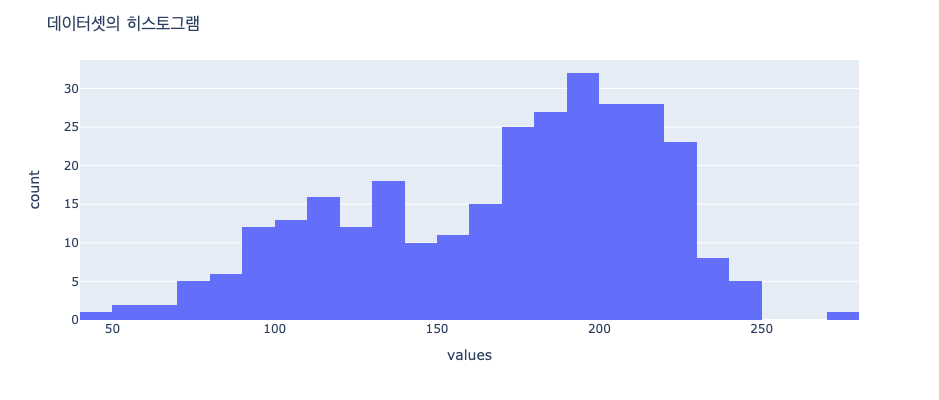

In [26]:
# plot the data
fig = px.histogram(df, x='values')
fig.layout.title = '데이터셋의 히스토그램'
fig.layout.width = 1250
fig.layout.height = 400
fig

위 데이터를 관찰해보면 아래와 같은 특징을 볼 수 있다.
- bimodal distribution
- mode 약 120, 200
> 즉, 분포의 특징으로 클러스터가 두개 있을 것으로 생각됨. ($k=2$)

#### GMM(Gaussian Mixture Model)을 활용한 데이터 클러스터링.
    1. 각 데이터 포인트에 대하여 cluster 0을 선택할 확률을 **p** cluster 1를 선택할 확률을 **(1-p)**로 선택함.
    2. 
    3. 반복함.


In [40]:
data_ = df['values'].values
p1 = tfd.Uniform(name='p', low=0., high=1.).sample()
p2 = 1 - p1
p = tf.stack([p1, p2])

rv_assignment = tfd.Categorical(name="assignment",probs=p)
assignment = rv_assignment.sample(sample_shape=data_.shape[0])

[P_, assignment_] = [p.numpy(), assignment.numpy()]

In [42]:
rv_sds = tfd.Uniform(name="rv_sds", low=[0., 0.], high=[100., 100.])
print (str(rv_sds))

rv_centers = tfd.Normal(name="rv_centers", loc=[120., 190.], scale=[10., 10.])

tfp.distributions.Uniform("rv_sds", batch_shape=[2], event_shape=[], dtype=float32)


In [43]:
sds = rv_sds.sample()
print ("shape of sds sample:",sds.shape)
centers = rv_centers.sample()

shape of sds sample: (2,)


In [ ]:

    


rv_assignments = tfd.Categorical(probs=tf.stack([0.4, 0.6]))
assignments = rv_assignments.sample(sample_shape=10)

# and to combine it with the observations:
rv_observations = tfd.MixtureSameFamily(
    mixture_distribution=rv_assignments,
    components_distribution=tfd.Normal(
        loc=centers,
        scale=sds))

observations = rv_observations.sample(sample_shape=10)

[    
    assignments_,
    observations_,
    sds_,
    centers_
] = evaluate([
    assignments,
    observations,
    sds,
    centers
])

print("simulated data: ", observations_[:4], "...")
print("Random assignments: ", assignments_[:4], "...")
print("Assigned center: ", centers_[:4], "...")
print("Assigned standard deviation: ", sds_[:4],"...")

joint log prob

In [ ]:
- 중심값과 std에 대한 pror로 투 클러스터링 만들기..

In [ ]:
여튼 정밀도나 분산이나 뭐든 표준편차와 관련된 랜덤변수 추정 ... unifrom...
중심값 normal dist

## 3.2 수렴 판정하기

## 3.3 MCMC에 대한 유용한 팁

## 3.4 결론

---

### Reference
- https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter3_MCMC/Ch3_IntroMCMC_TFP.ipynb